# MLPRegressor

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter("ignore")

In [216]:
all_mae = {}

## Почасовой прогноз

#### Один параметр

In [218]:
energo = pd.read_csv('result.csv', index_col='Местное время в Красноярске')
# energo[['Генерация, МВт*ч\\', 'Потребление, МВт*ч', 'T', 'Po', 'U', 'Ff', 'VV']].head(5)

In [135]:
target = 'Потребление, МВт*ч'
names = [target]

In [136]:
energo = energo[names]

In [137]:
four_old = energo.iloc[: 24 * 7 * 4]
n_four_old = four_old.shape[0]
n_four_old

672

In [138]:
three_new = energo.iloc[energo.shape[0] - 24 * 7 * 3 -24*7 : -24*7]
n_three_new = three_new.shape[0]
n_three_new

504

In [139]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.concat((four_old, three_new)))

In [140]:
analysis_length = 72
preemption_length = 168

In [141]:
train_x = ([scaler.transform(four_old)[i: i+analysis_length] for i in range(n_four_old - analysis_length)] +
    [scaler.transform(three_new)[i: i+analysis_length] for i in range(n_three_new - analysis_length)])

In [142]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [143]:
gr_train_x = list(map(np.concatenate, train_x))

In [144]:
train_subs = np.concatenate((scaler.transform(four_old)[analysis_length-n_four_old:],
    scaler.transform(three_new)[analysis_length-n_three_new:])).T

In [145]:
train_y = train_subs[-1]

In [146]:
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1).fit(gr_train_x, train_y)

In [147]:
series = scaler.transform(three_new)[-analysis_length:].T.tolist()

In [148]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 3230.68it/s]


In [149]:
y_true = [i[-1] for i in scaler.transform(energo.iloc[-preemption_length-analysis_length:])]

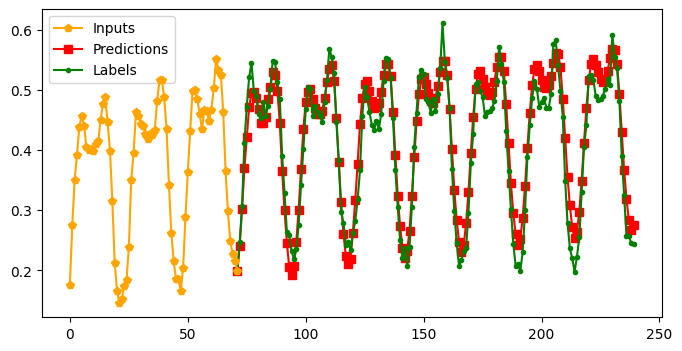

In [150]:
r1 = np.array(range(len(y_true[:analysis_length])))
r2 = np.array(range(len(y_true[:analysis_length])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:analysis_length], zorder=10,
         color='orange', label='Inputs', marker='p')
plt.plot(r2, series[-1][analysis_length-1:],
         color='red', label='Predictions', marker='s')
plt.plot(r2, y_true[analysis_length-1:],
         color='green', label='Labels', marker='.')
_ = plt.legend()

plt.show()

In [151]:
all_mae["hourly univariate"] = abs(np.array(series[-1][analysis_length:]) - np.array(y_true[analysis_length:])).mean()
print("MAE:", all_mae["hourly univariate"])

MAE: 0.025971322518613095


#### Несколько параметров

In [152]:
energo = pd.read_csv('result.csv')

In [153]:
labels = [
    'Генерация, МВт*ч\\',
    'T',
    'Po',
    'U', 'Ff', 'VV'
]
target = 'Потребление, МВт*ч'
names = labels + [target]

In [154]:
energo = energo[names]

In [155]:
four_old = energo.iloc[: 24 * 7 * 4]
n_four_old = four_old.shape[0]
n_four_old

672

In [156]:
three_new = energo.iloc[energo.shape[0] - 24 * 7 * 3 -24*7 : -24*7]
n_three_new = three_new.shape[0]
n_three_new

504

In [157]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.concat((four_old, three_new)))

In [158]:
train_x = ([scaler.transform(four_old)[i: i+analysis_length] for i in range(n_four_old - analysis_length)] +
    [scaler.transform(three_new)[i: i+analysis_length] for i in range(n_three_new - analysis_length)])

In [159]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [160]:
gr_train_x = list(map(np.concatenate, train_x))

In [161]:
train_subs = np.concatenate((scaler.transform(four_old)[analysis_length-n_four_old:],
    scaler.transform(three_new)[analysis_length-n_three_new:])).T

In [162]:
train_y = train_subs[-1]

In [163]:
sub_models = [MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1) for _ in train_subs[:-1]]
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [164]:
_ = g_model.fit(gr_train_x, train_y)

In [165]:
for i in tqdm.tqdm(range(len(sub_models))):
    sub_models[i].fit(s_train_x[i], train_subs[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.14s/it]


In [166]:
series = scaler.transform(three_new)[-analysis_length:].T.tolist()

In [167]:
for _ in tqdm.tqdm(range(preemption_length)):
    for i in range(sh-1):
        series[i].append(sub_models[i].predict([series[i][-analysis_length:]])[0])

100%|███████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 531.65it/s]


In [168]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 2365.61it/s]


In [169]:
y_true = [i[-1] for i in scaler.transform(energo.iloc[-preemption_length-analysis_length:])]

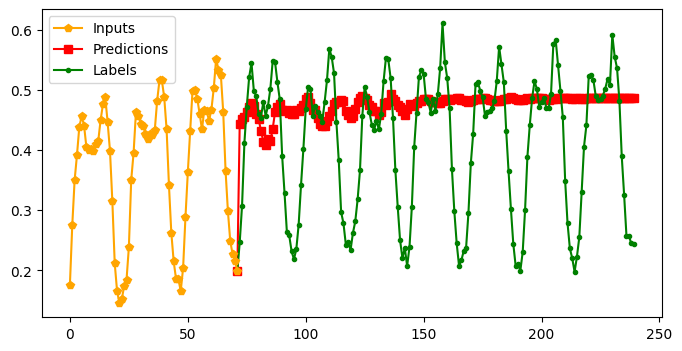

In [170]:
r1 = np.array(range(len(y_true[:analysis_length])))
r2 = np.array(range(len(y_true[:analysis_length])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:analysis_length], zorder=10,
         color='orange', label='Inputs', marker='p')
plt.plot(r2, series[-1][analysis_length-1:],
         color='red', label='Predictions', marker='s')
plt.plot(r2, y_true[analysis_length-1:],
         color='green', label='Labels', marker='.')
_ = plt.legend()

plt.show()

In [171]:
all_mae["hourly multivariate"] = abs(np.array(series[-1][analysis_length:]) - np.array(y_true[analysis_length:])).mean()
print("MAE:", all_mae["hourly multivariate"])

MAE: 0.09515591430838691


## Посуточный прогноз

#### Один параметр

In [172]:
energo = pd.read_csv('result.csv')

In [173]:
target = 'Потребление, МВт*ч'
names = [target]

In [174]:
days = len(energo[target])
hours = days // 24

In [175]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in names}

In [176]:
energo_d = pd.DataFrame(d)

In [177]:
n_old = 260
old = energo_d.iloc[: n_old]

In [178]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(old)

In [179]:
analysis_length = 30
preemption_length = 30

In [180]:
train_x = ([scaler.transform(old)[i: i+analysis_length] for i in range(n_old - analysis_length)])

In [181]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [182]:
gr_train_x = list(map(np.concatenate, train_x))

In [183]:
train_subs = scaler.transform(old)[analysis_length-n_old:].T

In [184]:
train_y = train_subs[-1]

In [185]:
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1).fit(gr_train_x, train_y)

In [186]:
series = scaler.transform(old)[-analysis_length:].T.tolist()

In [187]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3750.38it/s]


In [188]:
y_true = [i[-1] for i in scaler.transform(energo_d.iloc[-preemption_length-analysis_length:])]

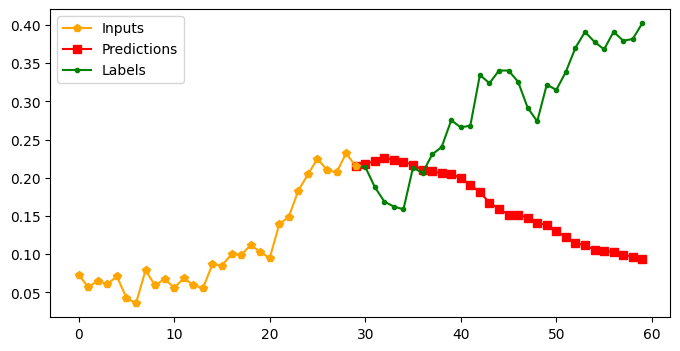

In [189]:
r1 = np.array(range(len(y_true[:analysis_length])))
r2 = np.array(range(len(y_true[:analysis_length])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:analysis_length], zorder=10,
         color='orange', label='Inputs', marker='p')
plt.plot(r2, series[-1][analysis_length-1:],
         color='red', label='Predictions', marker='s')
plt.plot(r2, y_true[analysis_length-1:],
         color='green', label='Labels', marker='.')
_ = plt.legend()

plt.show()

In [190]:
all_mae["daily univariate"] = abs(np.array(series[-1][analysis_length:]) - np.array(y_true[analysis_length:])).mean()
print("MAE:", all_mae["daily univariate"])

MAE: 0.1481311806415708


#### Несколько параметров

In [191]:
labels = [
    'Генерация, МВт*ч\\',
    'T',
    # 'Po',
    # 'U', 'Ff', 'VV'
]
target = 'Потребление, МВт*ч'
names = labels + [target]

In [192]:
days = len(energo[target])
hours = days // 24

In [193]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in names}

In [194]:
energo_d = pd.DataFrame(d)

In [195]:
n_old = 260
old = energo_d.iloc[: n_old]

In [196]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(old)

In [197]:
train_x = ([scaler.transform(old)[i: i+analysis_length] for i in range(n_old - analysis_length)])

In [198]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [199]:
gr_train_x = list(map(np.concatenate, train_x))

In [200]:
train_subs = scaler.transform(old)[analysis_length-n_old:].T

In [201]:
train_y = train_subs[-1]

In [202]:
sub_models = [MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1) for _ in train_subs[:-1]]
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [203]:
_ = g_model.fit(gr_train_x, train_y)

In [204]:
for i in tqdm.tqdm(range(len(sub_models))):
    sub_models[i].fit(s_train_x[i], train_subs[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


In [205]:
series = scaler.transform(old)[-analysis_length:].T.tolist()

In [206]:
for _ in tqdm.tqdm(range(preemption_length)):
    for i in range(sh-1):
        series[i].append(sub_models[i].predict([series[i][-analysis_length:]])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2000.02it/s]


In [207]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3750.16it/s]


In [208]:
y_true = [i[-1] for i in scaler.transform(energo_d.iloc[-preemption_length-analysis_length:])]

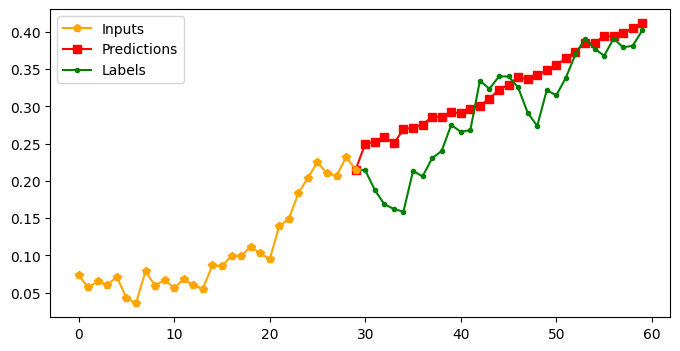

In [209]:
r1 = np.array(range(len(y_true[:analysis_length])))
r2 = np.array(range(len(y_true[:analysis_length])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:analysis_length], zorder=10,
         color='orange', label='Inputs', marker='p')
plt.plot(r2, series[-1][analysis_length-1:],
         color='red', label='Predictions', marker='s')
plt.plot(r2, y_true[analysis_length-1:],
         color='green', label='Labels', marker='.')
_ = plt.legend()

plt.show()

In [210]:
all_mae["daily multivariate"] = abs(np.array(series[-1][analysis_length:]) - np.array(y_true[analysis_length:])).mean()
print("MAE:", all_mae["daily multivariate"])

MAE: 0.03619022261478451


## Сравнение

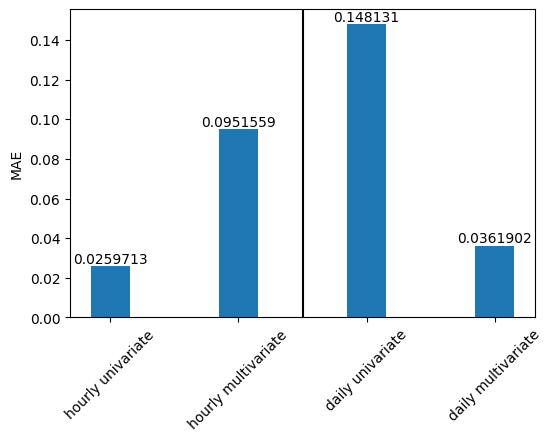

In [211]:
x = np.arange(len(all_mae))
width = 0.3
y = all_mae.values()

plt.figure(figsize=(6, 4))
bar1 = plt.bar(x, y, width)
plt.bar_label(bar1)
plt.xticks(ticks=x, labels=all_mae.keys(), rotation=45)
plt.ylabel(f'MAE')
plt.axvline(x=1.5, color='black')
plt.show()